pygame 2.6.1 (SDL 2.28.4, Python 3.13.3)
Hello from the pygame community. https://www.pygame.org/contribute.html
- Click and drag to draw
- Press ENTER when finished
- Press SPACE to clear


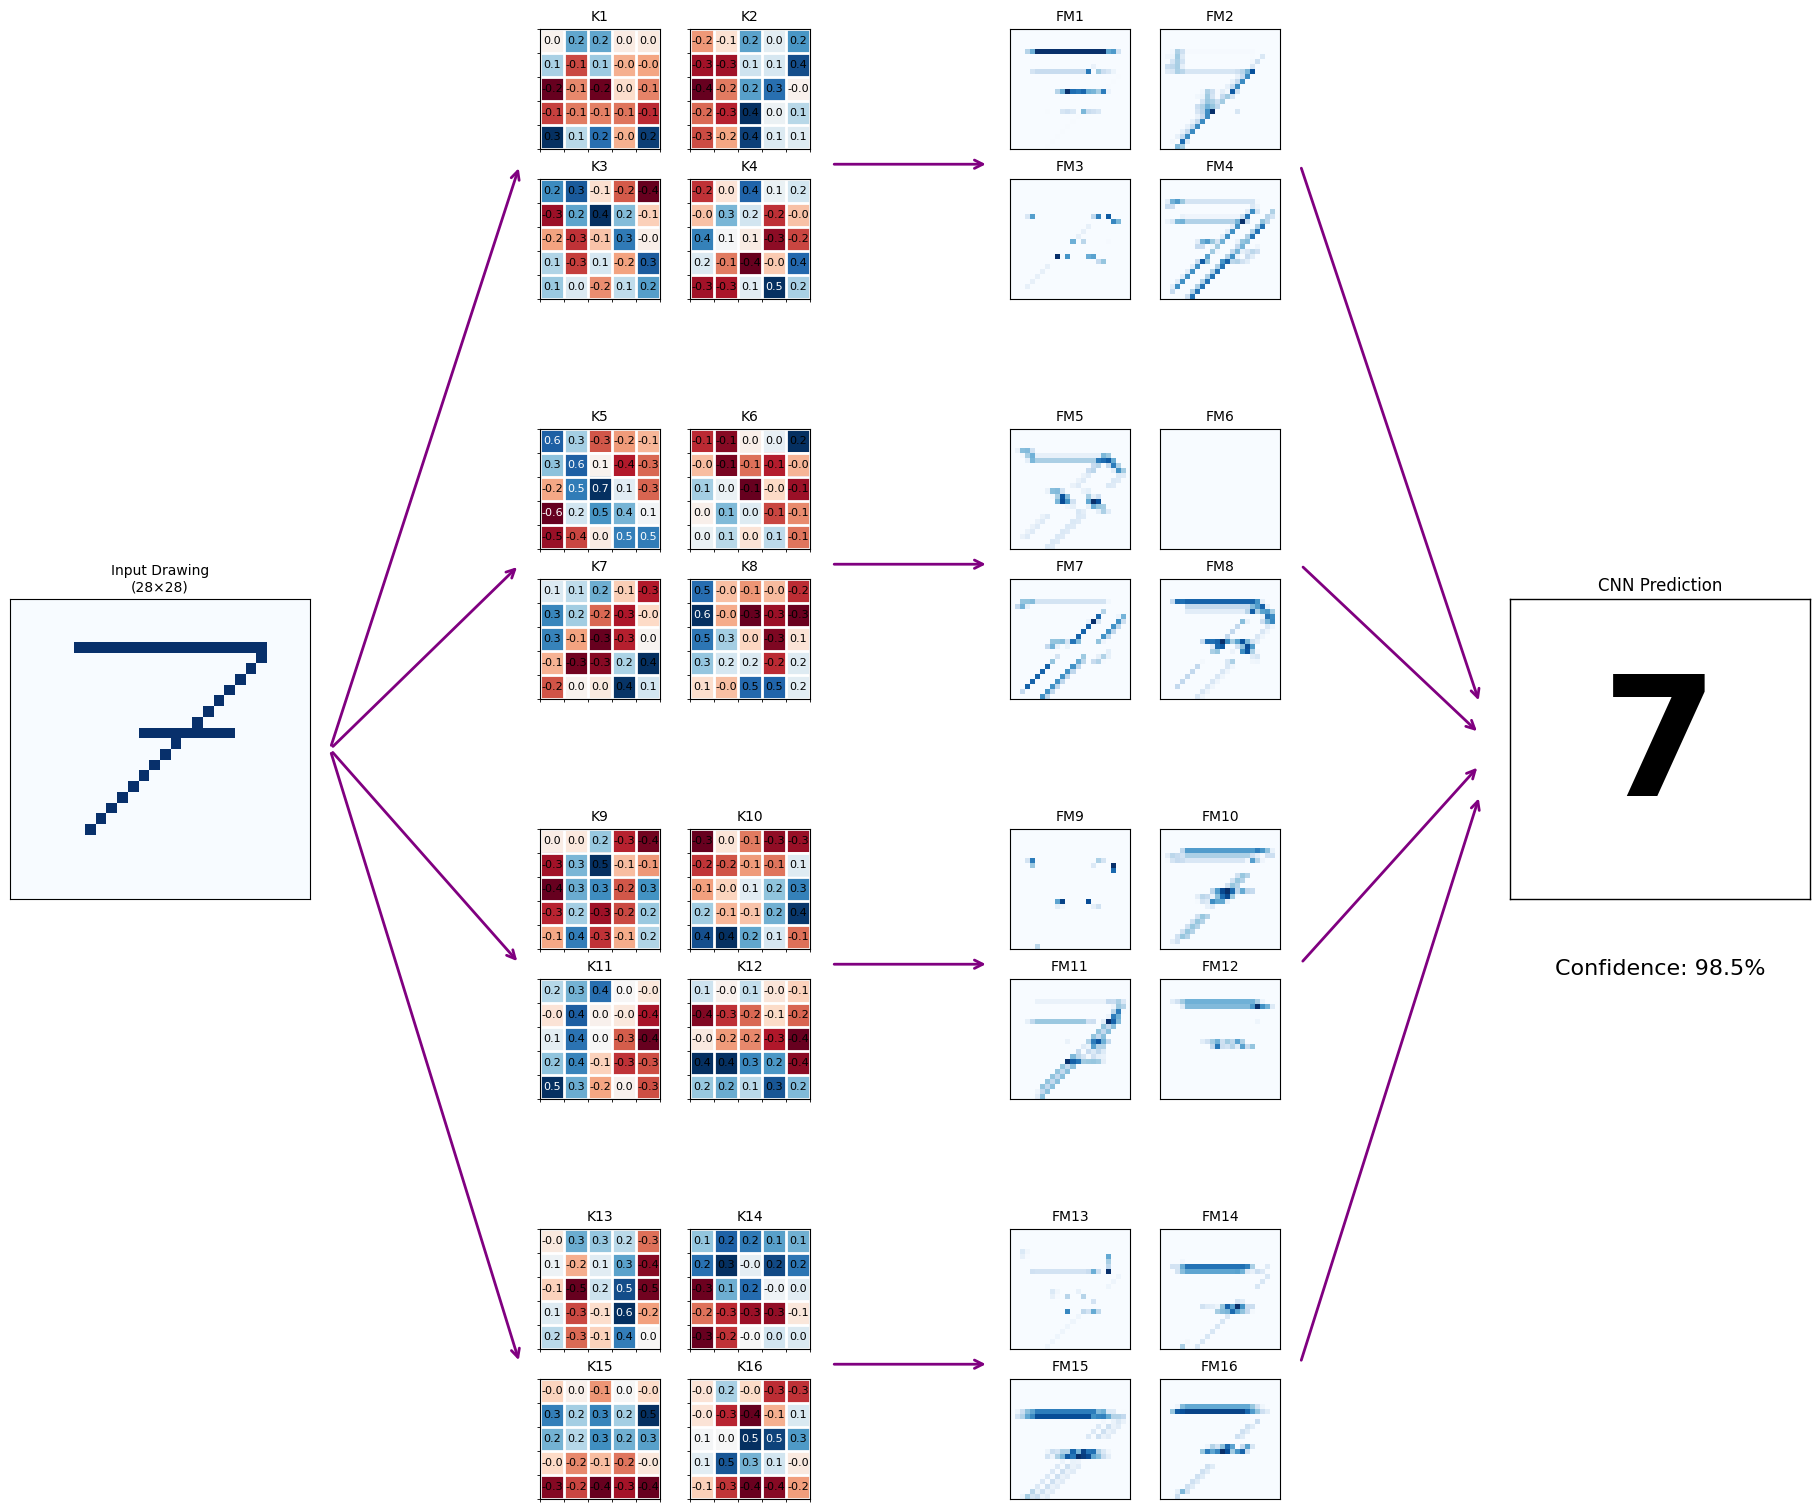

In [1]:
import pygame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy import ndimage


class MinimalCNN(nn.Module):
    def __init__(self):
        super(MinimalCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 14 * 14, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
        

def load_model():
    model = MinimalCNN()
    model.load_state_dict(torch.load('mnist_cnn.pth', map_location='cpu'))
    model.eval()
    return model
    

def center_and_normalize_digit(digit_array, target_size=20):
    rows, cols = np.where(digit_array > 0)
    
    if len(rows) == 0:
        return digit_array
    
    min_row, max_row = rows.min(), rows.max()
    min_col, max_col = cols.min(), cols.max()
    
    digit_region = digit_array[min_row:max_row+1, min_col:max_col+1]
    
    height, width = digit_region.shape
    scale = min(target_size / height, target_size / width)
    
    if scale < 1.0:
        new_height = int(height * scale)
        new_width = int(width * scale)
        digit_region = ndimage.zoom(digit_region, (new_height/height, new_width/width))
    
    centered_digit = np.zeros((28, 28))
    
    region_height, region_width = digit_region.shape
    start_row = (28 - region_height) // 2
    start_col = (28 - region_width) // 2
    
    centered_digit[start_row:start_row+region_height, start_col:start_col+region_width] = digit_region
    
    return centered_digit
    

def calculate_center_of_mass(digit_array):
    rows, cols = np.where(digit_array > 0)
    if len(rows) == 0:
        return 14, 14
    
    weights = digit_array[rows, cols]
    center_row = np.average(rows, weights=weights)
    center_col = np.average(cols, weights=weights)
    
    return center_row, center_col
    

def fine_tune_centering(digit_array):
    center_row, center_col = calculate_center_of_mass(digit_array)
    
    target_center = 13.5
    shift_row = int(round(target_center - center_row))
    shift_col = int(round(target_center - center_col))
    
    shift_row = max(-10, min(10, shift_row))
    shift_col = max(-10, min(10, shift_col))
    
    if shift_row != 0 or shift_col != 0:
        digit_array = ndimage.shift(digit_array, (shift_row, shift_col), cval=0.0)
    
    return digit_array
    

def preprocess_drawing(digit_array):
    centered = center_and_normalize_digit(digit_array)
    final = fine_tune_centering(centered)
    
    tensor = torch.FloatTensor(final)
    normalized = (tensor - 0.5) / 0.5
    input_tensor = normalized.unsqueeze(0).unsqueeze(0)
    
    return input_tensor, final
    

def predict_digit_improved(model, digit_array):
    input_tensor, processed_array = preprocess_drawing(digit_array)
    
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    return predicted.item(), confidence.item(), probabilities.squeeze().numpy(), processed_array
    

def draw_digit():
    WIDTH, HEIGHT = 560, 560
    BG_COLOR = (255, 255, 255)
    
    running = True
    grid_array = []
    
    pygame.init()
    window = pygame.display.set_mode((WIDTH, HEIGHT))
    pygame.display.set_caption("Draw Digit - Press ENTER when done")
    window.fill(BG_COLOR)
    
    def draw_grid():
        block_size = int(WIDTH/28)
        
        for i in range(28):
            for j in range(28):
                grid_block = pygame.Rect(i * block_size, j * block_size, block_size, block_size)
                color = (255, 255, 255)
                grid_array.append((grid_block, color))
    
    def draw_rectangles():
        for rect, color in grid_array:
            pygame.draw.rect(window, color, rect)
            pygame.draw.rect(window, (200, 200, 200), rect, 1)
    
    def get_digit_array():
        digit = np.zeros((28, 28))
        
        for row in range(28):
            for col in range(28):
                index = col * 28 + row
                rect, color = grid_array[index]
                
                if color == (0, 0, 0):
                    digit[row, col] = 0.9
        
        return digit
    
    def clear_grid():
        for i in range(len(grid_array)):
            rect, _ = grid_array[i]
            grid_array[i] = (rect, (255, 255, 255))
    
    draw_grid()
    
    print("- Click and drag to draw")
    print("- Press ENTER when finished")
    print("- Press SPACE to clear")
    
    digit_array = None
    clock = pygame.time.Clock()
    
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_RETURN:
                    digit_array = get_digit_array()
                    running = False
                    
                elif event.key == pygame.K_SPACE:
                    clear_grid()
        
        if pygame.mouse.get_pressed()[0]:
            mouse_pos = pygame.mouse.get_pos()
            for index, (rect, color) in enumerate(grid_array):
                if rect.collidepoint(mouse_pos):
                    grid_array[index] = (rect, (0, 0, 0))
        
        window.fill(BG_COLOR)
        draw_rectangles()
        pygame.display.flip()
        clock.tick(60)
    
    pygame.quit()
    return digit_array
    

class CNNVisualizer:
    def __init__(self, input_size=(28, 28), filter_size=(5, 5), num_filters=16):
        self.input_size = input_size
        self.filter_size = filter_size
        self.num_filters = num_filters
        self.output_size = (
            input_size[0] - filter_size[0] + 1,
            input_size[1] - filter_size[1] + 1
        )
        
        # Load model and get prediction
        self.model = load_model()
        self.input_data = draw_digit()
        
        # Get prediction
        if self.input_data is not None and np.sum(self.input_data) > 0:
            self.predicted_digit, self.confidence, _, _ = predict_digit_improved(self.model, self.input_data)
        else:
            self.predicted_digit, self.confidence = None, None
        
        self.filter_bias = np.array([
            -0.239532, -0.072666, -0.314909, -0.080079,
            -0.389541, -0.328099, -0.207792, -0.395359,
            -0.297987, -0.252624, -0.270118, -0.361449,
            -0.312527, -0.246792, -0.169581, -0.321820
        ])
        
        self.filters = [
            # All 16 filters from original code
            np.array([
                [ 0.034361,  0.155623,  0.155404,  0.024031,  0.021075],
                [ 0.113252, -0.103069,  0.121010, -0.036676, -0.044628],
                [-0.177898, -0.063570, -0.173520,  0.003580, -0.067112],
                [-0.108495, -0.072979, -0.068658, -0.075095, -0.121726],
                [ 0.261523,  0.102344,  0.208250, -0.036057,  0.248987]
            ]),
            np.array([
                [-0.164493, -0.052078,  0.221191,  0.048543,  0.237214],
                [-0.325108, -0.327648,  0.088302,  0.073561,  0.358889],
                [-0.390266, -0.197874,  0.221417,  0.307766, -0.008510],
                [-0.219068, -0.299751,  0.404388,  0.030677,  0.116388],
                [-0.251845, -0.150579,  0.378763,  0.061342,  0.057149]
            ]),
            np.array([
                [ 0.226063,  0.304590, -0.068229, -0.239610, -0.382903],
                [-0.330220,  0.187886,  0.364535,  0.152686, -0.099211],
                [-0.160093, -0.278723, -0.114885,  0.254945, -0.029979],
                [ 0.103608, -0.267326,  0.052802, -0.159418,  0.301716],
                [ 0.129132,  0.046037, -0.183536,  0.084744,  0.195730]
            ]),
            np.array([
                [-0.235487,  0.027779,  0.445910,  0.117232,  0.172051],
                [-0.042242,  0.294520,  0.175279, -0.239800, -0.041845],
                [ 0.390903,  0.093039,  0.050455, -0.311016, -0.209348],
                [ 0.153696, -0.142813, -0.359839, -0.027814,  0.438758],
                [-0.288537, -0.279088,  0.139171,  0.536328,  0.232867]
            ]),
            np.array([
                [ 0.598541,  0.291771, -0.324483, -0.200284, -0.137526],
                [ 0.336646,  0.594149,  0.051801, -0.435893, -0.292972],
                [-0.175570,  0.519181,  0.714222,  0.143931, -0.300636],
                [-0.566797,  0.198878,  0.450326,  0.373537,  0.089364],
                [-0.477121, -0.354287,  0.022131,  0.509213,  0.521843]
            ]),
            np.array([
                [-0.105250, -0.133675,  0.014314,  0.038614,  0.198177],
                [-0.028788, -0.139729, -0.070405, -0.110954, -0.034230],
                [ 0.084112,  0.036687, -0.148817, -0.010178, -0.124065],
                [ 0.016131,  0.101289,  0.046608, -0.090744, -0.056823],
                [ 0.036691,  0.073399,  0.001397,  0.069750, -0.068765]
            ]),
            np.array([
                [ 0.096189,  0.141901,  0.233445, -0.052485, -0.266369],
                [ 0.296569,  0.178962, -0.182905, -0.271630, -0.035664],
                [ 0.303031, -0.115183, -0.347676, -0.261664,  0.031994],
                [-0.094394, -0.334520, -0.312685,  0.167682,  0.433148],
                [-0.202212,  0.027577,  0.004936,  0.424872,  0.113835]
            ]),
            np.array([
                [ 0.482118, -0.011729, -0.076859, -0.019033, -0.213682],
                [ 0.593986, -0.044601, -0.335339, -0.268026, -0.329367],
                [ 0.464048,  0.287098,  0.028334, -0.305840,  0.065351],
                [ 0.307783,  0.209158,  0.196530, -0.216150,  0.189215],
                [ 0.050310, -0.012032,  0.493170,  0.499812,  0.178159]
            ]),
            np.array([
                [ 0.022207,  0.008461,  0.215623, -0.276479, -0.361644],
                [-0.309447,  0.250616,  0.484950, -0.077687, -0.133653],
                [-0.376902,  0.267726,  0.321378, -0.212572,  0.312336],
                [-0.273899,  0.201945, -0.311675, -0.231771,  0.212747],
                [-0.114191,  0.353332, -0.257306, -0.104889,  0.185157]
            ]),
            np.array([
                [-0.307513,  0.006132, -0.133066, -0.267815, -0.258981],
                [-0.204808, -0.174808, -0.099887, -0.139412,  0.099499],
                [-0.093891, -0.027894,  0.092913,  0.196585,  0.295982],
                [ 0.177795, -0.066545, -0.051155,  0.225716,  0.400448],
                [ 0.369491,  0.412878,  0.239564,  0.114213, -0.146664]
            ]),
            np.array([
                [ 0.177425,  0.268482,  0.407933,  0.039001, -0.017302],
                [-0.027973,  0.442634,  0.017986, -0.010518, -0.361805],
                [ 0.086586,  0.398214,  0.041617, -0.255886, -0.448530],
                [ 0.236947,  0.362642, -0.072589, -0.314105, -0.274692],
                [ 0.527694,  0.279910, -0.152621,  0.018700, -0.274901]
            ]),
            np.array([
                [ 0.090388, -0.010179,  0.103306, -0.039848, -0.083538],
                [-0.359861, -0.283518, -0.219068, -0.066723, -0.224030],
                [-0.030598, -0.161026, -0.182522, -0.308877, -0.389178],
                [ 0.403287,  0.405051,  0.265382,  0.237208, -0.351423],
                [ 0.159551,  0.203856,  0.115661,  0.349146,  0.184584]
            ]),
            np.array([
                [-0.011786,  0.313637,  0.251639,  0.189341, -0.256456],
                [ 0.068593, -0.155033,  0.104754,  0.332399, -0.449500],
                [-0.081307, -0.499630,  0.160275,  0.524438, -0.480259],
                [ 0.111363, -0.314406, -0.053967,  0.585696, -0.178033],
                [ 0.189987, -0.264355, -0.080847,  0.418051,  0.035949]
            ]),
            np.array([
                [ 0.085184,  0.207735,  0.177061,  0.128295,  0.109057],
                [ 0.190007,  0.264415, -0.003902,  0.236497,  0.183821],
                [-0.324101,  0.111900,  0.197018, -0.016800,  0.001897],
                [-0.195271, -0.254089, -0.287485, -0.293427, -0.067098],
                [-0.330049, -0.248553, -0.032681,  0.025036,  0.010600]
            ]),
            np.array([
                [-0.046910,  0.020938, -0.138568,  0.046199, -0.035325],
                [ 0.326205,  0.184626,  0.315675,  0.184064,  0.455892],
                [ 0.236866,  0.161586,  0.295411,  0.240804,  0.265910],
                [-0.038998, -0.154089, -0.084542, -0.178805, -0.002895],
                [-0.334915, -0.230596, -0.366511, -0.298806, -0.369044]
            ]),
            np.array([
                [-0.020607,  0.206660, -0.047611, -0.318499, -0.310762],
                [-0.023440, -0.330900, -0.447586, -0.127754,  0.120847],
                [ 0.052603,  0.047112,  0.539292,  0.501998,  0.325047],
                [ 0.096856,  0.469737,  0.280054,  0.141934, -0.003951],
                [-0.072420, -0.305021, -0.442866, -0.404888, -0.159460]
            ])
        ][:num_filters]
        
        # Generate feature maps
        if self.input_data is not None:
            self.output_maps = self.apply_convolution()
        else:
            self.output_maps = []

    
    def apply_convolution(self):
        output_maps = []
        
        for f in range(self.num_filters):
            output_map = np.zeros(self.output_size)
            
            for i in range(self.output_size[0]):
                for j in range(self.output_size[1]):
                    # Should use the preprocessed version:
                    _, processed_data = preprocess_drawing(self.input_data)
                    patch = processed_data[i:i+self.filter_size[0], j:j+self.filter_size[1]]
                    # patch = self.input_data[i:i+self.filter_size[0], j:j+self.filter_size[1]]
                    output_map[i, j] = np.sum(patch * self.filters[f])
                    output_map[i, j] = max(0, output_map[i, j] + self.filter_bias[f])
            
            output_maps.append(output_map)
        
        return output_maps

    
    def visualize_full_matrices(self, show_numbers_on_filters=True, decimals=1):
        if self.input_data is None:
            print("No drawing to visualize!")
            return
            
        # Set up the figure with grid layout (wider for 4th column)
        fig = plt.figure(figsize=(20, 20))
        
        def plot_matrix(ax, matrix, title, cmap='Blues', value_format='.1f', show_grid=True, show_numbers=False):
            im = ax.imshow(matrix, cmap=cmap, interpolation='nearest')
            ax.set_title(title, fontsize=10)
            
            if show_grid and matrix.shape[0] <= 10 and matrix.shape[1] <= 10:
                ax.set_xticks(np.arange(-.5, matrix.shape[1], 1), minor=True)
                ax.set_yticks(np.arange(-.5, matrix.shape[0], 1), minor=True)
                ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.set_xticks([])
                ax.set_yticks([])
            
            if show_numbers and matrix.shape[0] <= 10 and matrix.shape[1] <= 10:
                fontsize = 8 if matrix.shape[0] <= 5 else 6
                
                for i in range(matrix.shape[0]):
                    for j in range(matrix.shape[1]):
                        value = matrix[i, j]
                        text_color = 'white' if abs(value) > 0.5 else 'black'
                        if isinstance(value, (int, np.integer)):
                            value_str = f"{value}"
                        else:
                            value_str = f"{value:{value_format}}"
                        ax.text(j, i, value_str, ha='center', va='center', 
                               color=text_color, fontsize=fontsize)
                        
            return ax
        
        # Calculate true center position based on actual top and bottom edges of all kernel blocks
        sub_height = 0.06
        v_spacing = 0.0001
        
        # Block 0 (top block): block_top = 0.85
        # - Top edge of block 0 = 0.85 + sub_height = 0.91
        top_edge = 0.85 + sub_height
        
        # Block 3 (bottom block): block_top = 0.25
        # - Bottom edge of block 3 = 0.25 - (sub_height + v_spacing) = 0.1899
        bottom_edge = (0.85 - (3 * 0.2)) - (sub_height + v_spacing)
        
        # True center between highest and lowest points
        true_center = (top_edge + bottom_edge) / 2
        
        # Center both input and prediction boxes at this true center
        box_height = 0.15
        centered_bottom = true_center - box_height / 2
        
        # Plot the input data (left column, perfectly centered)
        input_left = 0.05
        input_bottom = centered_bottom
        input_width = 0.15
        input_height = 0.15
        ax_input = fig.add_axes([input_left, input_bottom, input_width, input_height])
        plot_matrix(ax_input, self.input_data, 'Input Drawing\n(28×28)', show_numbers=False)
        
        # Store axes for arrows
        kernel_block_axes = []
        output_block_axes = []
        
        # Plot all kernels and feature maps in 4 vertical 2x2 blocks
        for block_num in range(4):
            block_kernel_axes = []
            block_output_axes = []
            
            block_top = 0.85 - (block_num * 0.2)
            
            for sub_row in range(2):
                for sub_col in range(2):
                    f = block_num * 4 + sub_row * 2 + sub_col
                    
                    kernel_base_left = 0.315  # Adjusted to match gap from feature maps to prediction
                    feature_base_left = 0.55
                    
                    sub_width = 0.06
                    sub_height = 0.06
                    
                    h_spacing = 0.015
                    v_spacing = 0.015
                    
                    left_kernel = kernel_base_left + sub_col * (sub_width + h_spacing)
                    left_feature = feature_base_left + sub_col * (sub_width + h_spacing)
                    bottom = block_top - sub_row * (sub_height + v_spacing)
                    
                    # Plot kernel
                    ax_filter = fig.add_axes([left_kernel, bottom, sub_width, sub_height])
                    plot_matrix(ax_filter, self.filters[f], f'K{f+1}', cmap='RdBu', show_numbers=show_numbers_on_filters)
                    block_kernel_axes.append(ax_filter)
                    
                    # Plot corresponding feature map
                    ax_output = fig.add_axes([left_feature, bottom, sub_width, sub_height])
                    plot_matrix(ax_output, self.output_maps[f], f'FM{f+1}', show_numbers=False)
                    block_output_axes.append(ax_output)
            
            kernel_block_axes.append((block_num, block_kernel_axes))
            output_block_axes.append((block_num, block_output_axes))

        
        # 4th column: Prediction result
        if self.predicted_digit is not None:
            # Prediction box exactly matches input box size and position for symmetry
            prediction_left = 0.8
            prediction_bottom = centered_bottom  # Same as input box
            prediction_width = 0.15   # Same as input box
            prediction_height = 0.15  # Same as input box
            
            ax_prediction = fig.add_axes([prediction_left, prediction_bottom, prediction_width, prediction_height])
            
            # Create a square with the predicted number
            ax_prediction.text(0.5, 0.5, str(self.predicted_digit), ha='center', va='center', 
                             fontsize=120, fontweight='bold', transform=ax_prediction.transAxes)
            
            ax_prediction.set_xlim(0, 1)
            ax_prediction.set_ylim(0, 1)
            ax_prediction.set_xticks([])
            ax_prediction.set_yticks([])
            ax_prediction.set_title('CNN Prediction', fontsize=12)
            
            # Add border
            for spine in ax_prediction.spines.values():
                spine.set_visible(True)
                spine.set_linewidth(1)
            
            # Add confidence text below the box
            confidence_percentage = self.confidence * 100
            fig.text(prediction_left + prediction_width/2, prediction_bottom - 0.03, 
                    f'Confidence: {confidence_percentage:.1f}%', 
                    ha='center', va='top', fontsize=16, transform=fig.transFigure)
        
        # Draw arrows using figure coordinates
        fig.canvas.draw()
        
        # Updated input box position for arrows
        input_bbox = ax_input.get_position()
        input_right = input_bbox.x1
        input_center_y = (input_bbox.y0 + input_bbox.y1) / 2
        
        def add_straight_arrow(fig, start_x, start_y, end_x, end_y, color='purple', width=2.0):
            arrow = patches.FancyArrowPatch(
                (start_x, start_y), (end_x, end_y),
                arrowstyle='->', color=color, linewidth=width,
                connectionstyle='arc3,rad=0',
                shrinkA=3, shrinkB=3,
                mutation_scale=15,
                transform=fig.transFigure, zorder=0
            )
            fig.add_artist(arrow)
        
        # Add arrows from input to each 2x2 kernel block
        for block_num, block_axes in kernel_block_axes:
            if block_axes:
                all_positions = []
                for ax in block_axes:
                    bbox = ax.get_position()
                    all_positions.extend([
                        (bbox.x0, bbox.y0),
                        (bbox.x1, bbox.y1)
                    ])
                
                if all_positions:
                    block_left = min(pos[0] for pos in all_positions) - 0.01
                    block_top = max(pos[1] for pos in all_positions)
                    block_bottom = min(pos[1] for pos in all_positions)
                    block_center_y = (block_top + block_bottom) / 2
                    
                    add_straight_arrow(fig, input_right + 0.01, input_center_y, block_left, block_center_y, color='purple')
        
        # Add arrows from each 2x2 kernel block to corresponding 2x2 feature map block
        for (k_block_num, k_axes), (o_block_num, o_axes) in zip(kernel_block_axes, output_block_axes):
            if k_axes and o_axes and k_block_num == o_block_num:
                k_positions = []
                for ax in k_axes:
                    bbox = ax.get_position()
                    k_positions.extend([
                        (bbox.x0, bbox.y0),
                        (bbox.x1, bbox.y1)
                    ])
                
                o_positions = []
                for ax in o_axes:
                    bbox = ax.get_position()
                    o_positions.extend([
                        (bbox.x0, bbox.y0),
                        (bbox.x1, bbox.y1)
                    ])
                
                if k_positions and o_positions:
                    k_right = max(pos[0] for pos in k_positions) + 0.01
                    k_top = max(pos[1] for pos in k_positions)
                    k_bottom = min(pos[1] for pos in k_positions)
                    k_center_y = (k_top + k_bottom) / 2
                    
                    o_left = min(pos[0] for pos in o_positions) - 0.01
                    o_top = max(pos[1] for pos in o_positions)
                    o_bottom = min(pos[1] for pos in o_positions)
                    o_center_y = (o_top + o_bottom) / 2
                    
                    add_straight_arrow(fig, k_right, k_center_y, o_left, o_center_y, color='purple')
        
        # Add arrows from each 2x2 feature map block to prediction
        if self.predicted_digit is not None and output_block_axes:
            # Get prediction box position
            pred_center_y = prediction_bottom + prediction_height / 2
            pred_left = prediction_left - 0.015  # Closer horizontally but short enough to avoid overlap
            
            # Add arrow from each feature map block to prediction
            for block_num, block_axes in output_block_axes:
                if block_axes:
                    # Calculate bounding box of this specific feature map block
                    block_positions = []
                    for ax in block_axes:
                        bbox = ax.get_position()
                        block_positions.extend([
                            (bbox.x0, bbox.y0),
                            (bbox.x1, bbox.y1)
                        ])
                    
                    if block_positions:
                        # Find rightmost edge and center of this block
                        block_right = max(pos[0] for pos in block_positions) + 0.01
                        block_top = max(pos[1] for pos in block_positions)
                        block_bottom = min(pos[1] for pos in block_positions)
                        block_center_y = (block_top + block_bottom) / 2
                        
                        # Calculate different target Y positions - closer together within middle 60% of box
                        pred_center_y = prediction_bottom + prediction_height / 2  # Recalculate center
                        box_height = prediction_height
                        box_center = pred_center_y
                        spread_range = box_height * 0.3  # Use 60% of box height (30% above and below center)
                        
                        if block_num == 0:  # Top block
                            target_y = box_center + spread_range * 0.5
                        elif block_num == 1:  # Second block
                            target_y = box_center + spread_range * 0.17
                        elif block_num == 2:  # Third block
                            target_y = box_center - spread_range * 0.17
                        else:  # Bottom block (3)
                            target_y = box_center - spread_range * 0.5
                        
                        # Arrow from this block to prediction (each at different Y position)
                        add_straight_arrow(fig, block_right, block_center_y, pred_left, target_y, color='purple')
        
        #plt.tight_layout()
        plt.show()

def main():

    try:
        visualizer = CNNVisualizer()
        if visualizer.input_data is not None and np.sum(visualizer.input_data) > 0:
            visualizer.visualize_full_matrices()
        else:
            print("No drawing detected or drawing is empty")
    except FileNotFoundError:
        print("Could not find 'mnist_cnn.pth' model file")
        print("Make sure the CNN is in the same directory")
    except Exception as e:
        print(f"Error: {e}")
        print("Make sure you have the required libraries installed:")
        print("torch torchvision pygame matplotlib scipy")

if __name__ == "__main__":
    main()

- Click and drag to draw
- Press ENTER when finished
- Press SPACE to clear


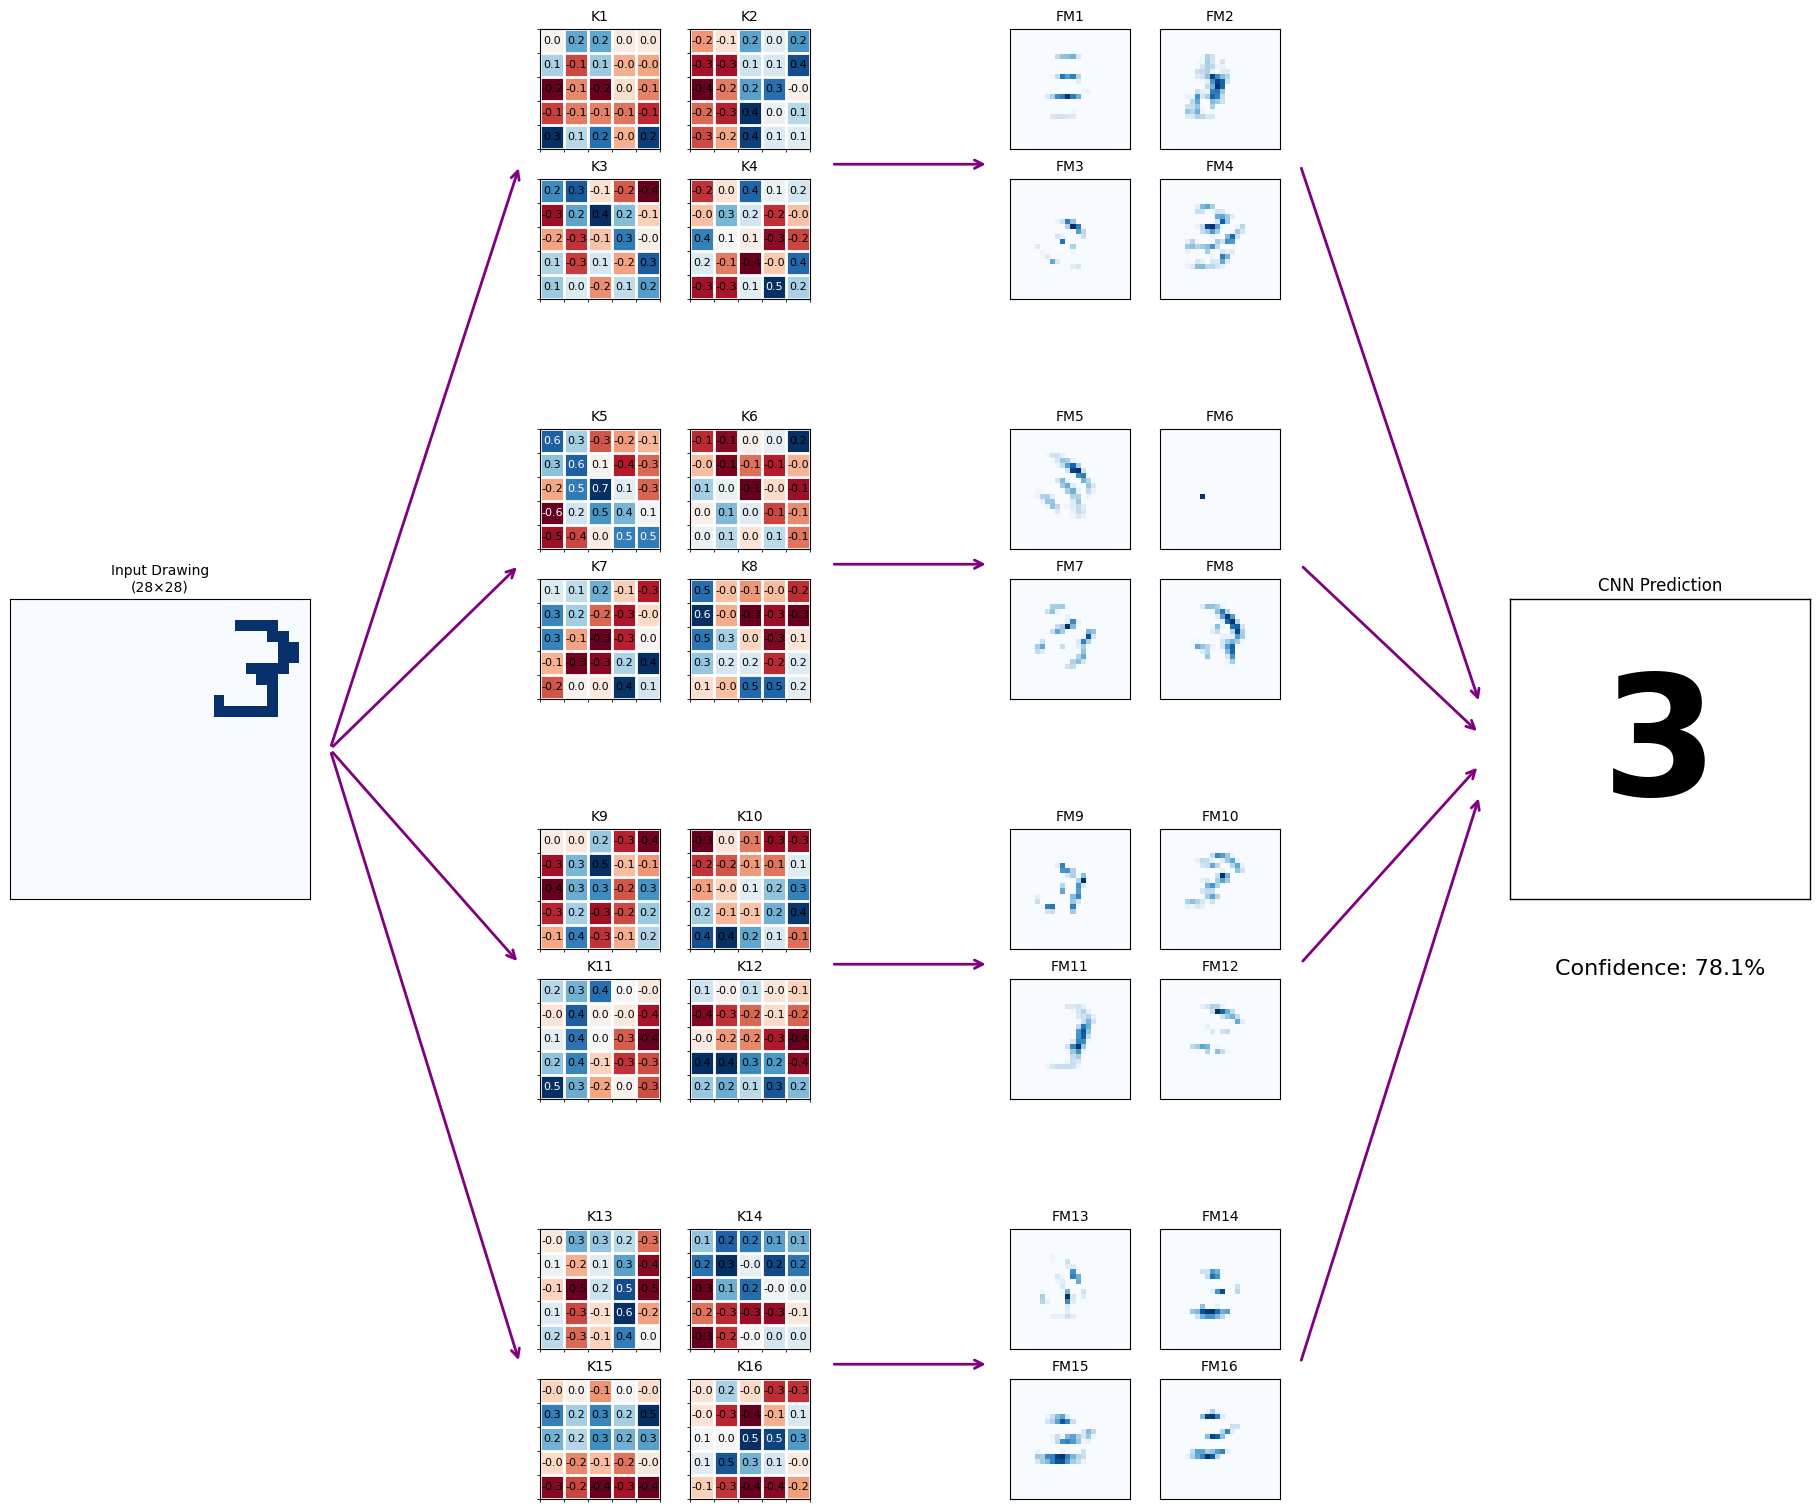

In [5]:
main()